In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from scipy import stats

: 

In [19]:
# Load data
#TFT_encoding_predictions = np.load('../data/model_preds/TFT_encoded_predictions.npy', allow_pickle=True)
TFT_predictions = np.load('../data/model_preds/TFT_predictions.npy', allow_pickle=True)
TFT_shortterm_predictions = np.load('../data/model_preds/TFT_shortterm_predictions.npy', allow_pickle=True)
TFT_longterm_predictions = np.load('../data/model_preds/TFT_longterm_predictions.npy', allow_pickle=True)
LSTM_predictions = np.load('../data/model_preds/LSTM_predictions.npy', allow_pickle=True)
ARIMA_predictions = np.load('../data/model_preds/ARIMA_predictions.npy', allow_pickle=True)
naive_predictions = np.load('../data/model_preds/naive_predictions.npy', allow_pickle=True)
tests = np.load('../data/model_preds/actual_sales.npy', allow_pickle=True)
data = pd.read_csv('../data/data_processed_plant_item_10_03_22.csv')

In [22]:
def add_shortterm(TFT_short, TFT_long, TFT):
    TFT[:, 0] = np.squeeze(TFT_short)
    return TFT


TFT_multi_preds = add_shortterm(TFT_shortterm_predictions, TFT_longterm_predictions, TFT_predictions)
print(TFT_multi_preds.shape)

(10451, 6)


In [21]:
np.save('../data/model_preds/multi_TFT_preds_V3', TFT_multi_preds, allow_pickle=True)

In [3]:
#classifications = np.load('forecast_classification.npy')

In [25]:
def create_ensemble_preds(clf, TFT_preds_clf):
    TFT_ensemble_predictions = np.zeros((len(clf), 6))
    for i in range(len(clf)):
        if clf[i] == 0:
            TFT_ensemble_predictions[i, :] = np.zeros((6))
        else:
            TFT_ensemble_predictions[i, :] = TFT_preds_clf[i, :]
    return TFT_ensemble_predictions


#TFT_ensemble_predictions = create_ensemble_preds(classifications, TFT_predictions)

In [5]:
def WMAPE2_calc(preds, tests):
    total_vol = np.sum(tests)
    print(total_vol)
    residuals = 0
    total_vol = np.sum(tests)
    for i in range(preds.shape[0]):
        pred = preds[i, :]
        for t in range(len(pred)):
            residuals += abs(pred[t] - tests[i, t])
    WMAPE_2 = (residuals / total_vol) * 100
    return WMAPE_2


def metric_test(preds, tests):
    MSEs = []
    MAPEs = []
    MAE = []
    for i in range(preds.shape[0]):
        pred = preds[i, :]
        test = tests[i, :]
        MSEs.append(mean_squared_error(test, pred))
        MAPEs.append(mean_absolute_percentage_error(test + 1, pred + 1))
        MAE.append(mean_absolute_error(test, pred))
    WMAPE_2 = WMAPE2_calc(preds, tests)
    print('mean squared error:                              ', round(np.mean(MSEs), 2))
    print('mean absolute error:                             ', round(np.mean(MAE), 2))
    print('mean absolute percentage error:          ', round(np.mean(MAPEs), 2), '%')
    print('mean absolute percentage error weighted: ', round(WMAPE_2, 2), '%')


def compare_performance(model_dict, tests):
    for model in list(model_dict.keys()):
        print(model)
        print('')
        metric_test(model_dict[model], tests)
        print('')


model_dict = {'TFT':TFT_predictions, 'LSTM':LSTM_predictions, 'ARIMA':ARIMA_predictions, 'naive':naive_predictions}
compare_performance(model_dict, tests)

TFT

3017473.0
mean squared error:                               28062.23
mean absolute error:                              33.83
mean absolute percentage error:           4.79 %
mean absolute percentage error weighted:  70.3 %

LSTM

3017473.0
mean squared error:                               151461.38
mean absolute error:                              79.53
mean absolute percentage error:           22.0 %
mean absolute percentage error weighted:  165.27 %

ARIMA

3017473.0
mean squared error:                               40993.61
mean absolute error:                              38.72
mean absolute percentage error:           4.47 %
mean absolute percentage error weighted:  80.46 %

naive

3017473.0
mean squared error:                               41915.37
mean absolute error:                              40.57
mean absolute percentage error:           3.35 %
mean absolute percentage error weighted:  84.3 %



In [6]:
def sum_over_plants(array, data):
    timeseries_list = list(data['timeseries'].unique())
    item_dict = {}
    for i in range(len(timeseries_list)):
        timeseries = data[data['timeseries'] == timeseries_list[i]]
        itemID = list(timeseries['ParentItemID'].unique())[0]
        if itemID not in list(item_dict.keys()):
            item_dict[itemID] = array[i, :]
        else:
            prev_vol = item_dict[itemID]
            new_vol = prev_vol + array[i, :]
            item_dict[itemID] = new_vol
    return item_dict

In [7]:
test_item_dict = sum_over_plants(tests, data)
ARIMA_preds_dict = sum_over_plants(ARIMA_predictions, data)
#TFT_encodings_preds_dict = sum_over_plants(TFT_encoding_predictions, data)
TFT_preds_dict = sum_over_plants(TFT_predictions, data)
LSTM_preds_dict = sum_over_plants(LSTM_predictions, data)
naive_preds_dict = sum_over_plants(naive_predictions, data)

In [33]:
def WMAPE2_calc(pred_dict, test_dict, model):
    residuals = 0
    total_vol = np.sum(list(test_dict.values()))
    for itemID in list(pred_dict.keys()):
        pred = pred_dict[itemID] + 0.1
        test = test_dict[itemID] + 0.1
        for t in range(1):
            residuals += abs(pred[t] - test[t])
    WMAPE_2 = (np.sum(residuals) / total_vol) * 100
    print('Weighted and aggregated MAPE for:', model, ':', round(WMAPE_2, 2), '%')

In [34]:
models = ['TFT encodings', 'TFT', 'LSTM', 'ARIMA', 'Naive']
#WMAPE2_calc(TFT_encodings_preds_dict, test_item_dict, models[0])
WMAPE2_calc(TFT_preds_dict, test_item_dict, models[1])
WMAPE2_calc(LSTM_preds_dict, test_item_dict, models[2])
WMAPE2_calc(ARIMA_preds_dict, test_item_dict, models[3])
WMAPE2_calc(naive_preds_dict, test_item_dict, models[4])

Weighted and aggregated MAPE for: TFT : 8.46 %
Weighted and aggregated MAPE for: LSTM : 15.28 %
Weighted and aggregated MAPE for: ARIMA : 7.38 %
Weighted and aggregated MAPE for: Naive : 7.63 %


In [23]:
def assess_worst_performers(tests, TFT_multi_preds, Naive_preds, ARIMA_preds, threshold):
    indices = []
    for i in range(tests.shape[0]):
        test = tests[i, :]
        mae = mean_absolute_error(test, TFT_multi_preds[i, :])
        if mae > threshold:
            indices.append(i)
    poor_performers_test = tests[indices, :]
    poor_performers_TFT = TFT_multi_preds[indices, :]
    poor_performers_naive = Naive_preds[indices, :]
    poor_performers_ARIMA = ARIMA_preds[indices, :]
    print(len(indices))
    return poor_performers_test, poor_performers_TFT, poor_performers_naive, poor_performers_ARIMA 


threshold = 1500
poor_performers_test, poor_performers_TFT, poor_performers_naive, poor_performers_ARIMA = assess_worst_performers(tests, 
                                                                                                                    TFT_multi_preds, 
                                                                                                                    naive_predictions,
                                                                                                                    ARIMA_predictions, 
                                                                                                                    threshold)

19


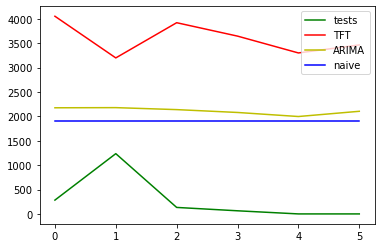

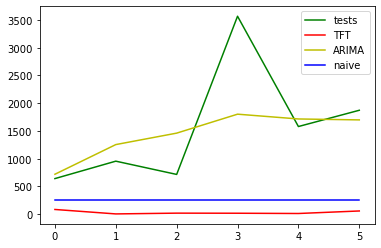

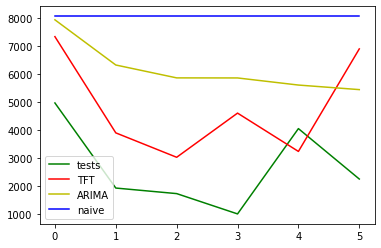

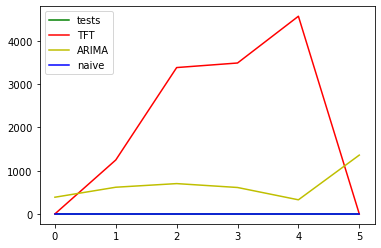

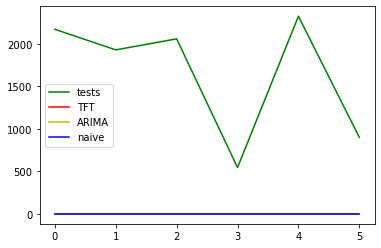

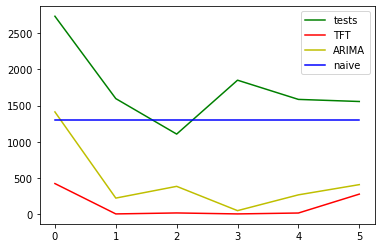

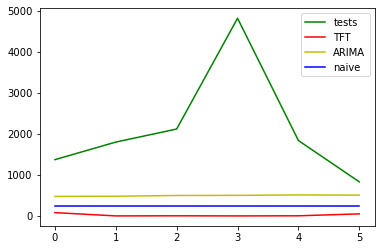

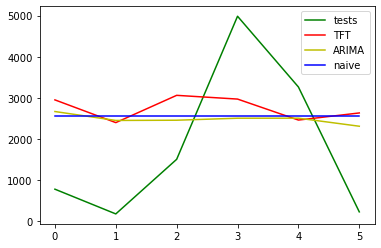

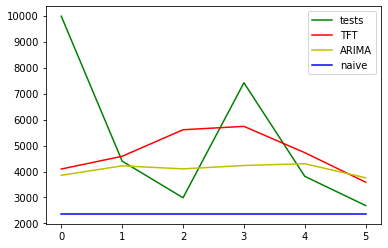

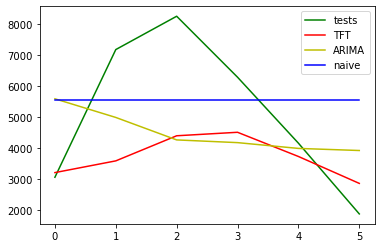

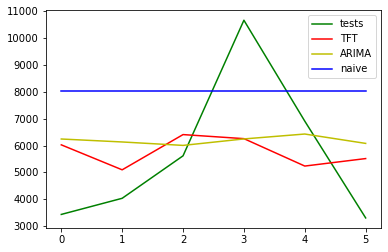

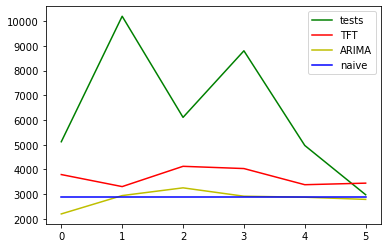

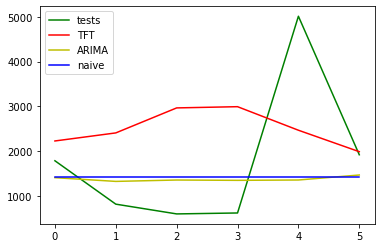

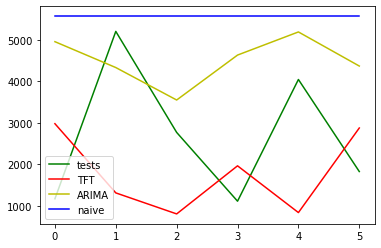

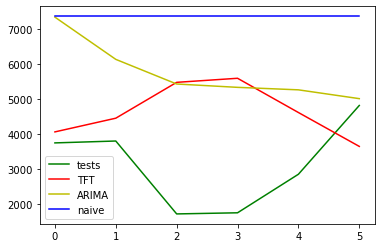

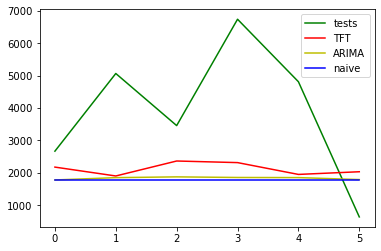

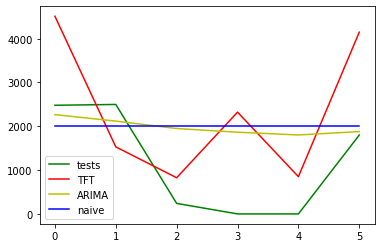

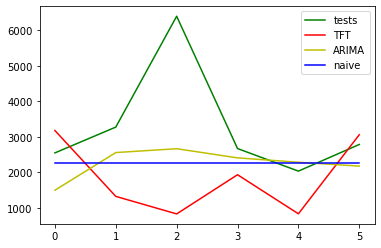

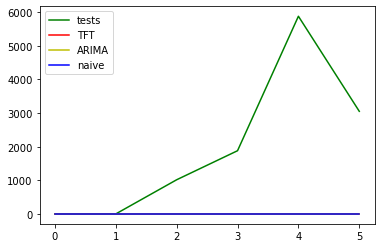

In [24]:
def plot_preds(tests, TFTs, naives, arimas):
    for i in range(tests.shape[0]):
        plt.figure()
        plt.plot(range(len(tests[i, :])), tests[i, :], c='g', label='tests')
        plt.plot(range(len(tests[i, :])), TFTs[i, :], c='r', label='TFT')
        plt.plot(range(len(tests[i, :])), arimas[i, :], c='y', label='ARIMA')
        plt.plot(range(len(tests[i, :])), naives[i, :], c='b', label='naive')
        plt.legend()
        plt.plot()

plot_preds(poor_performers_test, poor_performers_TFT, poor_performers_naive, poor_performers_ARIMA)